## Triple Chaos Encryption

In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from math import log
from scipy.integrate import solve_ivp

Create an output folder to store the results

In [2]:
os.makedirs("outputs", exist_ok=True)

### Image IO and Plotting Utils

To Load an image from disk as a NumPy array.
- mode='color' => shape (H, W, 3)
- mode='gray'  => shape (H, W)

In [3]:
def load_image(image_path, mode='color'):
    if mode == 'gray':
        pil_img = Image.open(image_path).convert('L')
        return np.array(pil_img)
    else:
        pil_img = Image.open(image_path).convert('RGB')
        return np.array(pil_img)

To save a NumPy array to disk as a PNG

In [4]:
def save_image(img_array, out_path):
    if len(img_array.shape) == 2:
        out_img = Image.fromarray(img_array.astype('uint8'), 'L')
    else:
        out_img = Image.fromarray(img_array.astype('uint8'), 'RGB')
    out_img.save(out_path)
    print(f"Saved: {out_path}")

To Display the image and optionally save to 'save_path'.

In [ ]:
def show_and_save_image(img_array, title="Image", save_path=None):
    plt.figure(figsize=(5, 5))
    if len(img_array.shape) == 2:
        plt.imshow(img_array, cmap='gray', vmin=0, vmax=255)
    else:
        plt.imshow(img_array)
    plt.title(title)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()

To Plot and show the histogram of an image, optionally saves to 'save_path'.

In [ ]:
def show_and_save_histogram(img_array, title="Histogram", save_path=None):
    plt.figure()
    if len(img_array.shape) == 2:
        plt.hist(img_array.ravel(), bins=256, range=(0,255), color='gray')
    else:
        colors = ('b','g','r')
        for i, c in enumerate(colors):
            hist = cv2.calcHist([img_array.astype('uint8')],[i],None,[256],[0,256])
            plt.plot(hist, color=c)
    plt.title(title)
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()

To Plot horizontally adjacent pixel correlation, optionally saves to file.

In [ ]:
def show_and_save_correlation(img_array, sample_size=1024, title="Correlation", save_path=None):
    
    if len(img_array.shape) == 3:
        gray = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2GRAY)
    else:
        gray = img_array
    h, w = gray.shape
    samples_x = []
    samples_y = []
    for _ in range(sample_size):
        r = random.randint(0, h-1)
        c = random.randint(0, w-2)
        px1 = gray[r, c]
        px2 = gray[r, c+1]
        samples_x.append(px1)
        samples_y.append(px2)
    plt.figure()
    plt.scatter(samples_x, samples_y, s=2)
    
    plt.title(title)
    plt.xlabel("Pixel (r,c)")
    plt.ylabel("Pixel (r,c+1)")
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()

# Chaos Map Functions

### Arnold's Cat Map

One iteration of Arnold's Cat:  
&ensp;&ensp;&ensp;&ensp;x', y' = ((x + y) mod n), ((x + 2*y) mod n)

In [8]:
def arnold_cat_transform(img):
    n = img.shape[0]
    transformed = np.zeros_like(img)
    for x in range(n):
        for y in range(n):
            new_x = (x + y) % n
            new_y = (x + 2*y) % n
            transformed[new_x, new_y] = img[x, y]
    return transformed

Applying Arnold's Cat transform 'iterations' times.

In [9]:
def arnold_cat_encrypt(img_array, iterations):
    h, w = img_array.shape[:2]
    if h != w:
        raise ValueError("Arnold's Cat requires a square image!")
    result = img_array.copy()
    for _ in range(iterations):
        result = arnold_cat_transform(result)
    return result

Estimate period for n x n image returning to original under Arnold's Cat.

In [10]:
def arnold_cat_period(n):
    if (n % 2 == 0) and 5**int(round(log(n/2,5))) == int(n/2):
        return 3*n
    elif 5**int(round(log(n,5))) == int(n):
        return 2*n
    elif (n % 6 == 0) and 5**int(round(log(n/6,5))) == int(n/6):
        return 2*n
    else:
        return int(12*n/7)

Decrypt by continuing from 'iterations' to full period.

In [11]:
def arnold_cat_decrypt(img_array, iterations):
    n = img_array.shape[0]
    per = arnold_cat_period(n)
    result = img_array.copy()
    for i in range(iterations, per):
        result = arnold_cat_transform(result)
    return result

### Henon Map (XOR based)

To Convert a list of bits (0/1) into a list of bytes [0..255]

In [12]:
def bits_to_bytes(bits):
    assert len(bits) % 8 == 0
    out = []
    for i in range(0, len(bits), 8):
        val = 0
        for b in bits[i:i+8]:
            val = (val << 1) | b
        out.append(val)
    return out

Generate 'num_bits' bits from Henon map.

In [13]:
def henon_map_sequence(num_bits, x0=0.1, y0=0.1, a=1.4, b=0.3):
    x = x0
    y = y0
    bits = []
    for _ in range(num_bits):
        x_next = y + 1 - a*(x**2)
        y_next = b*x
        x, y = x_next, y_next
        bits.append(0 if x <= 0.4 else 1)
    return bits

XOR each pixel with Henon-based pseudorandom bytes.

In [14]:
def henon_encrypt(img_array, x0=0.1, y0=0.1):
    shape = img_array.shape
    if len(shape) == 2:
        h, w = shape
        c = 1
    else:
        h, w, c = shape

    total_pixels = h*w
    needed_bytes = total_pixels*c
    needed_bits = needed_bytes*8

    henon_bits = henon_map_sequence(needed_bits, x0, y0)
    henon_stream = bits_to_bytes(henon_bits)

    encrypted = np.zeros_like(img_array)
    idx = 0
    for r in range(h):
        for cc in range(w):
            if c == 1:
                px = img_array[r, cc]
                encrypted[r, cc] = px ^ henon_stream[idx]
                idx += 1
            else:
                px_r, px_g, px_b = img_array[r, cc]
                encrypted[r, cc, 0] = px_r ^ henon_stream[idx]
                encrypted[r, cc, 1] = px_g ^ henon_stream[idx+1]
                encrypted[r, cc, 2] = px_b ^ henon_stream[idx+2]
                idx += 3
    return encrypted

In [15]:
def henon_decrypt(img_array, x0=0.1, y0=0.1):
    return henon_encrypt(img_array, x0, y0)

### Rössler Map

The Rössler map is derived from the Rössler system, a set of continuous differential equations that exhibit chaotic behavior. When discretized, the Rössler map provides a way to analyze chaos in discrete time steps.

The discrete form of the Rössler system is given by:

\[
\begin{aligned}
X_{t+1} &= X_t + (-Y_t - Z_t) \cdot \Delta t \\
Y_{t+1} &= Y_t + (X_t + aY_t) \cdot \Delta t \\
Z_{t+1} &= Z_t + (b + Z_t (X_t - c)) \cdot \Delta t
\end{aligned}
\]

where \(a\), \(b\), and \(c\) are control parameters that influence the system’s chaotic nature, \($\Delta t$\) represents the step size.

In [16]:
def rossler_system(t, state, a=0.2, b=0.2, c=5.7):
    x, y, z = state
    dx = -y - z
    dy = x + a * y
    dz = b + z * (x - c)
    return [dx, dy, dz]

In [17]:
def generate_rossler_sequence(length, x0=0.1, y0=0.1, z0=0.1, a=0.432, b=2, c=4):
    t_span = [0, length * 0.1]  # Time interval
    t_eval = np.linspace(t_span[0], t_span[1], length)  # Sample points
    sol = solve_ivp(rossler_system, t_span, [x0, y0, z0], args=(a, b, c), t_eval=t_eval)
    seq = np.abs(sol.y[0] * 1e6) % 256  # Scale values to byte range
    return seq.astype(np.uint8)

In [18]:
def rossler_encrypt(img_array, x0=0.1, y0=0.1, z0=0.1):
    shape = img_array.shape
    h, w, c = shape if len(shape) == 3 else (*shape, 1)
    total_pixels = h * w * c
    chaos_stream = generate_rossler_sequence(total_pixels, x0, y0, z0)
    encrypted = img_array.flatten() ^ chaos_stream
    return encrypted.reshape(shape)

In [19]:
def rossler_decrypt(img_array, x0=0.1, y0=0.1, z0=0.1):
    return rossler_encrypt(img_array, x0, y0, z0)  # XOR-based is reversible

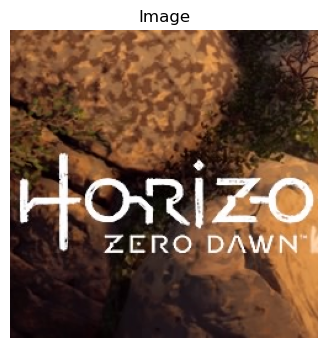

In [38]:
input_image = load_image("input.png", mode='color')
show_and_save_image(input_image)

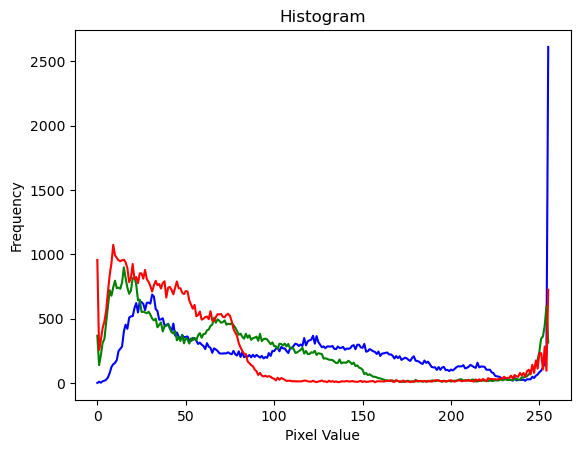

In [39]:
show_and_save_histogram(input_image)

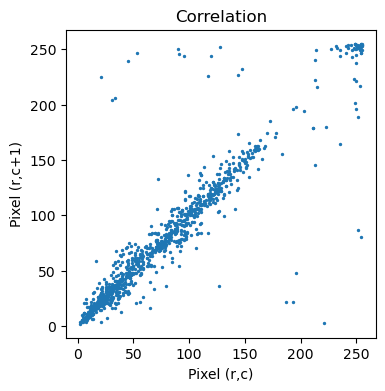

In [33]:
show_and_save_correlation(input_image)

### TRIPLE-CHAOS (Arnold -> Henon -> Rossler)

#### Arnold Cat Map

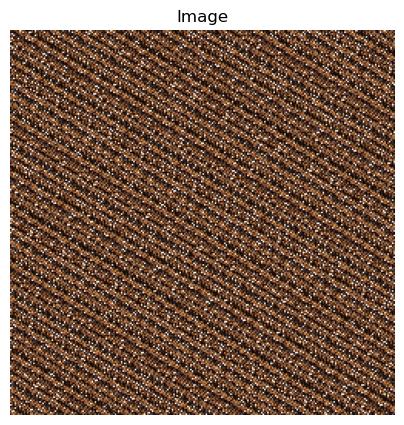

In [28]:
arnold_encrypt_img = arnold_cat_encrypt(input_image, 5)
show_and_save_image(arnold_encrypt_img)

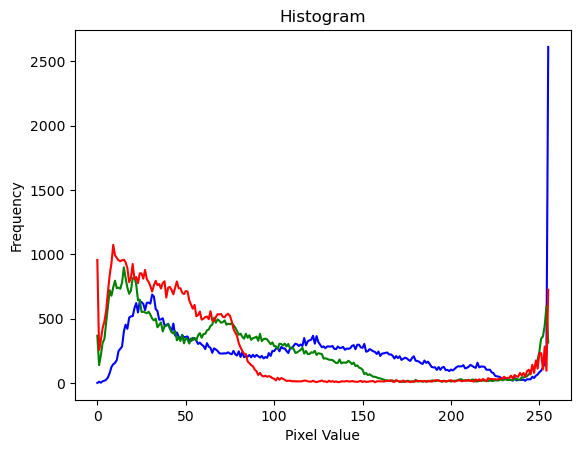

In [36]:
show_and_save_histogram(arnold_encrypt_img)

#### Henon Map

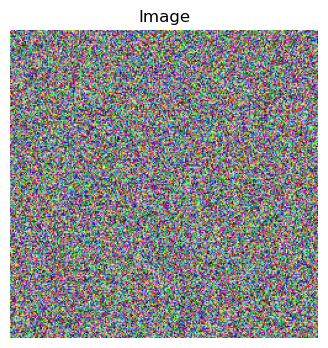

In [45]:
henon_encrypt_img = henon_encrypt(arnold_encrypt_img)
show_and_save_image(henon_encrypt_img)

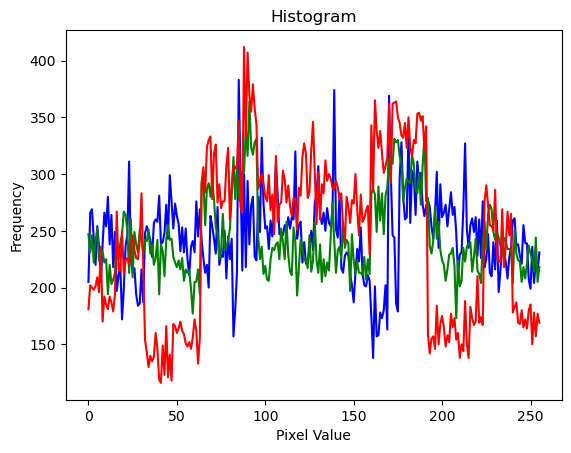

In [46]:
show_and_save_histogram(henon_encrypt_img)

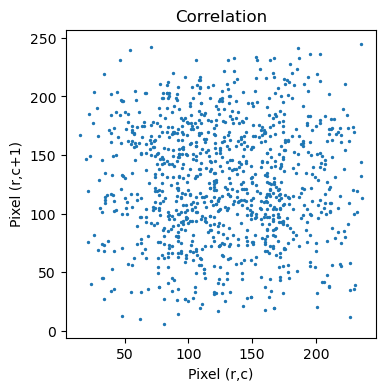

In [47]:
show_and_save_correlation(henon_encrypt_img)

#### Rössler Map

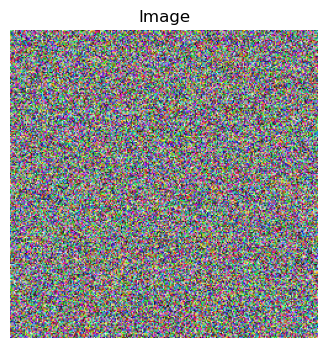

In [ ]:
final_encrypt_img = rossler_encrypt(henon_encrypt_img)
show_and_save_image(final_encrypt_img)

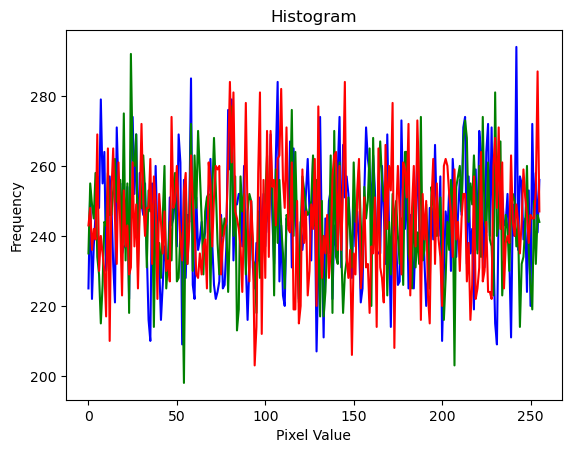

In [ ]:
show_and_save_histogram(final_encrypt_img)

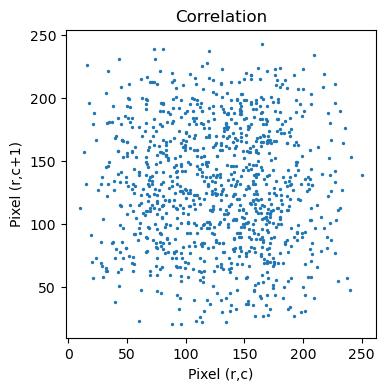

In [ ]:
show_and_save_correlation(final_encrypt_img)

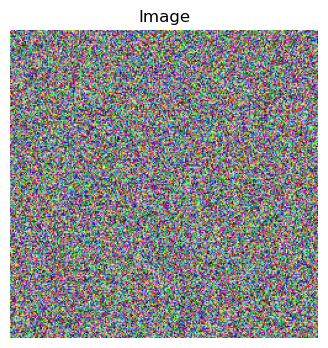

In [ ]:
rossler_decrypt_img = rossler_decrypt(final_encrypt_img)
show_and_save_image(rossler_decrypt_img)

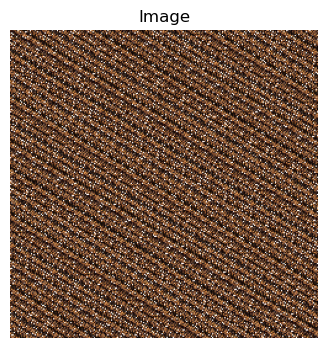

In [56]:
henon_decrypt_img = henon_decrypt(rossler_decrypt_img)
show_and_save_image(henon_decrypt_img)

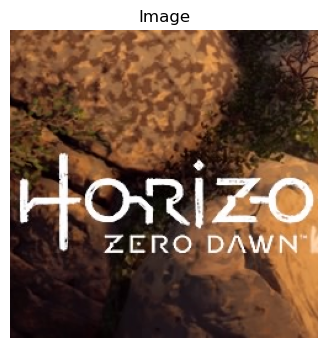

In [58]:
final_decrypt_img = arnold_cat_decrypt(henon_decrypt_img, 5)
show_and_save_image(final_decrypt_img)

In [59]:
mse = np.mean((final_decrypt_img - input_image)**2)
print(f"MSE between original and final decrypted = {mse:.6f}")

MSE between original and final decrypted = 0.000000
